# サンプルノートブック
* データのロードから学習・予測、submitファイルの出力までを実行できるサンプルコードです。
* データのパスは実行環境に合わせて設定してください。

In [32]:
#!python3.8 -V

Python 3.8.0


![](../document/explanation.png)

In [2]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', None)
import datetime
import os
import re
import glob
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
sns.set()

from scipy import signal
from scipy import fftpack
import lightgbm as lgb
import xgboost
import optuna.integration.lightgbm as lgb_opt

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# from sktime.transformations.panel.compose import ColumnConcatenator
# from sktime.classification.interval_based import TimeSeriesForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# import pycaret
# from pycaret.regression import *
from pycaret.classification import *

# read csv
学習データとテストデータを読み込みます。

In [137]:
# データへのパスは実行環境に合わせて編集してください。
DIR_TRAIN_NORMAL = "../data/train/normal/"
DIR_TRAIN_ANOMALY = "../data/train/anomaly/"
DIR_TEST = "../data/test/"
sampling_rate = 50000 #50kHz
COL_NAMES = ["ch1","ch2","ch3","ch4","ch5","ch6","ch7"]

In [138]:
# 各データ数
print('number of normal data : ' + str(len(glob.glob(DIR_TRAIN_NORMAL + '*'))))
print('number of anomaly data : ' + str(len(glob.glob(DIR_TRAIN_ANOMALY + '*'))))
print('number of test data : ' + str(len(glob.glob(DIR_TEST + '*'))))

number of normal data : 350
number of anomaly data : 90
number of test data : 480


In [139]:
# フーリエ変換
# データ取得間隔 50kHz 
sampling_rate = 5000
n_frame = 15000 # 分割窓のコマ数
time_step = 1/ sampling_rate # 1/ 50kHz
han = signal.hann(n_frame) #ハニング窓を作成

def fourier(sample, ch):
    '''
    フーリエ変換後、1Hz以上の範囲で最大値になる周波数を返す
    sample : dataframe
    ch : channel name
    '''
    sample_freq = fftpack.fftfreq(len(sample), d=time_step)  # 周波数軸を生成
    y_fft = np.fft.fft((han)*(sample[ch]-np.mean(sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
    pidxs = np.where(sample_freq > 0)

    freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
    
    mfreq = freqs[freqs >= 10**1][power[freqs >= 10**1].argmax()] # ピーク周波数
    return mfreq

In [140]:
# 線形補間
def interpolate(data):
    data = pd.DataFrame(data).interpolate(axis=0)
    return data

In [141]:
# diff = lambda x: np.max(x) - np.min(x)

In [142]:
# normalデータ特徴量計算し、全データを結合
all_normal_train = pd.DataFrame()
for i, path in enumerate(glob.glob(DIR_TRAIN_NORMAL + '*')):
    # 通常データ
    normal_train = pd.read_csv(path, header=None)
    normal_train.columns = COL_NAMES
    normal_train = interpolate(normal_train)
    normal_train['No'] = i
    
    norm_train_summary = normal_train.groupby('No', group_keys=False).agg([np.mean, np.max, np.min, np.var])
    norm_train_summary.columns = norm_train_summary.columns.map('_'.join)
    
    x = pd.Series()
    for i, colname in enumerate(COL_NAMES):
        fft_temp = pd.Series(fourier(sample=normal_train, ch=colname))
        x = pd.concat([x, fft_temp], axis=0)
    x = list(x)
    
    for i, colname in enumerate(COL_NAMES):
        new_col = colname + '_fft'
        norm_train_summary[new_col] = x[i]
        
    all_normal_train = pd.concat([all_normal_train, norm_train_summary], axis=0).reset_index(drop=True)

In [143]:
all_normal_train.head()

,ch1_mean,ch1_amax,ch1_amin,ch1_var,ch2_mean,ch2_amax,ch2_amin,ch2_var,ch3_mean,ch3_amax,...,ch7_amax,ch7_amin,ch7_var,ch1_fft,ch2_fft,ch3_fft,ch4_fft,ch5_fft,ch6_fft,ch7_fft
0,-0.020650,1.4884,-3.1253,0.983228,-0.002536,0.53396,-1.1982,0.095150,-0.000217,0.14652,...,0.50630,-0.23216,0.012691,2204.0,2204.0,2204.0,11.666667,16.000000,2204.0,2204.0
1,0.010330,1.5259,-2.9649,0.948786,0.001634,0.57560,-1.2033,0.092300,0.000506,0.13736,...,0.48739,-0.21016,0.011897,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0
2,-0.014887,1.5061,-3.0605,0.990780,-0.002463,0.57393,-1.1647,0.095945,0.000366,0.13067,...,0.47756,-0.22379,0.012321,2204.0,2204.0,2204.0,11.666667,15.666667,2204.0,2204.0
3,-0.010146,1.4942,-2.9854,0.993707,-0.000214,0.52196,-1.2534,0.094518,0.000324,0.13752,...,0.46712,-0.22181,0.012342,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0
4,0.017884,1.5097,-3.1310,0.955935,0.002289,0.51766,-1.4075,0.092789,0.000385,0.15312,...,0.49112,-0.22430,0.011831,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0


In [144]:
all_normal_train['label'] = 0

In [145]:
# anomalyデータ特徴量計算し、全データを結合
all_anomal_train = pd.DataFrame()
for i, path in enumerate(glob.glob(DIR_TRAIN_ANOMALY + '*')):
    # 通常データ
    anomal_train = pd.read_csv(path, header=None)
    anomal_train.columns = COL_NAMES
    anomal_train = interpolate(anomal_train)
    anomal_train['No'] = i
    
    anomal_train_summary = anomal_train.groupby('No', group_keys=False).agg([np.mean, np.max, np.min, np.var])
    anomal_train_summary.columns = anomal_train_summary.columns.map('_'.join)
    
    x = pd.Series()
    for i, colname in enumerate(COL_NAMES):
        fft_temp = pd.Series(fourier(sample=anomal_train, ch=colname))
        x = pd.concat([x, fft_temp], axis=0)
    x = list(x)
    
    for i, colname in enumerate(COL_NAMES):
        new_col = colname + '_fft'
        anomal_train_summary[new_col] = x[i]
        
    all_anomal_train = pd.concat([all_anomal_train, anomal_train_summary], axis=0).reset_index(drop=True)

In [146]:
all_anomal_train['label'] = 1

In [147]:
train = pd.concat([all_normal_train, all_anomal_train], axis=0)

In [148]:
train.head()

,ch1_mean,ch1_amax,ch1_amin,ch1_var,ch2_mean,ch2_amax,ch2_amin,ch2_var,ch3_mean,ch3_amax,...,ch7_amin,ch7_var,ch1_fft,ch2_fft,ch3_fft,ch4_fft,ch5_fft,ch6_fft,ch7_fft,label
0,-0.020650,1.4884,-3.1253,0.983228,-0.002536,0.53396,-1.1982,0.095150,-0.000217,0.14652,...,-0.23216,0.012691,2204.0,2204.0,2204.0,11.666667,16.000000,2204.0,2204.0,0
1,0.010330,1.5259,-2.9649,0.948786,0.001634,0.57560,-1.2033,0.092300,0.000506,0.13736,...,-0.21016,0.011897,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0,0
2,-0.014887,1.5061,-3.0605,0.990780,-0.002463,0.57393,-1.1647,0.095945,0.000366,0.13067,...,-0.22379,0.012321,2204.0,2204.0,2204.0,11.666667,15.666667,2204.0,2204.0,0
3,-0.010146,1.4942,-2.9854,0.993707,-0.000214,0.52196,-1.2534,0.094518,0.000324,0.13752,...,-0.22181,0.012342,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0,0
4,0.017884,1.5097,-3.1310,0.955935,0.002289,0.51766,-1.4075,0.092789,0.000385,0.15312,...,-0.22430,0.011831,2204.0,2204.0,2204.0,11.666667,11.666667,2204.0,2204.0,0


In [149]:
# testデータ特徴量計算し、全データを結合
all_test = pd.DataFrame()
for i, path in enumerate(glob.glob(DIR_TEST + '*')):
    # testデータ
    test = pd.read_csv(path, header=None)
    test.columns = COL_NAMES
    test = interpolate(test)
    test['No'] = i
    
    test_summary = test.groupby('No', group_keys=False).agg([np.mean, np.max, np.min, np.var])
    test_summary.columns = test_summary.columns.map('_'.join)
    
    x = pd.Series()
    for i, colname in enumerate(COL_NAMES):
        fft_temp = pd.Series(fourier(sample=test, ch=colname))
        x = pd.concat([x, fft_temp], axis=0)
    x = list(x)
    
    for i, colname in enumerate(COL_NAMES):
        new_col = colname + '_fft'
        test_summary[new_col] = x[i]
        
    all_test = pd.concat([all_test, test_summary], axis=0).reset_index(drop=True)

In [150]:
all_test.head()

,ch1_mean,ch1_amax,ch1_amin,ch1_var,ch2_mean,ch2_amax,ch2_amin,ch2_var,ch3_mean,ch3_amax,...,ch7_amax,ch7_amin,ch7_var,ch1_fft,ch2_fft,ch3_fft,ch4_fft,ch5_fft,ch6_fft,ch7_fft
0,0.016756,1.861700,-3.354700,0.760079,0.001247,1.179900,-1.682000,0.131511,-0.000122,0.48629,...,0.70670,-0.341630,0.026807,2202.333333,2202.333333,18.333333,18.333333,11.666667,12.333333,2202.333333
1,-0.001471,1.941600,-2.307500,0.380887,-0.001500,1.969200,-1.844400,0.263752,-0.000156,1.21860,...,0.75830,-0.439200,0.042412,16.000000,2202.666667,32.000000,26.666667,26.666667,16.000000,2202.666667
2,0.033008,2.084300,-3.976200,1.746735,0.002873,0.591190,-1.415500,0.095300,0.000668,0.17678,...,0.65347,-0.262260,0.017436,2202.333333,2202.333333,2202.333333,11.666667,12.000000,2202.333333,2202.333333
3,0.006920,1.909500,-3.354400,0.746293,0.000220,1.150200,-1.746100,0.129144,0.000263,0.49375,...,0.71812,-0.356350,0.029490,2202.333333,2202.333333,19.666667,19.666667,19.666667,272.000000,2202.333333
4,-0.009314,1.788205,-2.426525,0.355888,-0.007156,1.574227,-1.867505,0.228460,-0.001874,1.58409,...,0.79251,-0.450984,0.045592,11.666667,2202.666667,22.333333,33.000000,33.000000,258.666667,2202.666667


In [176]:
from pycaret.classification import *
clf = setup(data = train, target = 'label', session_id=123, fold_strategy='stratifiedkfold', fold=2)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(440, 36)"
5,Missing Values,False
6,Numeric Features,35
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [177]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9218,0.9558,0.7812,0.8343,0.8067,0.7578,0.7586,0.3650
catboost,CatBoost Classifier,0.9088,0.9643,0.6719,0.8727,0.7544,0.6998,0.7119,3.0100
gbc,Gradient Boosting Classifier,0.9056,0.9281,0.7344,0.7971,0.7644,0.7055,0.7065,0.1100
rf,Random Forest Classifier,0.9023,0.9546,0.5469,0.9737,0.6999,0.6470,0.6857,0.4000
lightgbm,Light Gradient Boosting Machine,0.9022,0.9558,0.6719,0.8268,0.7389,0.6799,0.6869,0.0550
et,Extra Trees Classifier,0.8990,0.9466,0.5625,0.9206,0.6974,0.6413,0.6698,0.3550
ada,Ada Boost Classifier,0.8957,0.9209,0.6719,0.7910,0.7256,0.6620,0.6659,0.0950
lda,Linear Discriminant Analysis,0.8795,0.9318,0.5156,0.8696,0.6424,0.5753,0.6066,0.0250
lr,Logistic Regression,0.8762,0.8520,0.4531,0.9078,0.6040,0.5402,0.5863,1.5750
dt,Decision Tree Classifier,0.8730,0.8104,0.7031,0.6932,0.6981,0.6177,0.6178,0.9550


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              validate_parameters=1, verbosity=0)

In [178]:
# lgbm = create_model('lightgbm')
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9156,0.9460,0.7812,0.8065,0.7937,0.7406,0.7408
1,0.9281,0.9657,0.7812,0.8621,0.8197,0.7749,0.7764
Mean,0.9218,0.9558,0.7812,0.8343,0.8067,0.7578,0.7586
SD,0.0063,0.0098,0.0000,0.0278,0.0130,0.0172,0.0178


In [179]:
tuned_model = tune_model(xgb, n_iter = 500, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9221,0.9647,0.8438,0.7941,0.8182,0.7687,0.7692
1,0.9346,0.9744,0.8438,0.8438,0.8438,0.8024,0.8024
Mean,0.9284,0.9695,0.8438,0.8189,0.8310,0.7855,0.7858
SD,0.0063,0.0049,0.0000,0.0248,0.0128,0.0169,0.0166


In [180]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [181]:
prediction_holdout = predict_model(tuned_model, data=all_test)

In [182]:
prediction_holdout

,ch1_mean,ch1_amax,ch1_amin,ch1_var,ch2_mean,ch2_amax,ch2_amin,ch2_var,ch3_mean,ch3_amax,...,ch7_var,ch1_fft,ch2_fft,ch3_fft,ch4_fft,ch5_fft,ch6_fft,ch7_fft,Label,Score
0,0.016756,1.861700,-3.354700,0.760079,0.001247,1.179900,-1.682000,0.131511,-0.000122,0.486290,...,0.026807,2202.333333,2202.333333,18.333333,18.333333,11.666667,12.333333,2202.333333,0,0.9960
1,-0.001471,1.941600,-2.307500,0.380887,-0.001500,1.969200,-1.844400,0.263752,-0.000156,1.218600,...,0.042412,16.000000,2202.666667,32.000000,26.666667,26.666667,16.000000,2202.666667,0,0.9989
2,0.033008,2.084300,-3.976200,1.746735,0.002873,0.591190,-1.415500,0.095300,0.000668,0.176780,...,0.017436,2202.333333,2202.333333,2202.333333,11.666667,12.000000,2202.333333,2202.333333,1,0.8582
3,0.006920,1.909500,-3.354400,0.746293,0.000220,1.150200,-1.746100,0.129144,0.000263,0.493750,...,0.029490,2202.333333,2202.333333,19.666667,19.666667,19.666667,272.000000,2202.333333,0,0.9983
4,-0.009314,1.788205,-2.426525,0.355888,-0.007156,1.574227,-1.867505,0.228460,-0.001874,1.584090,...,0.045592,11.666667,2202.666667,22.333333,33.000000,33.000000,258.666667,2202.666667,0,0.9679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.008298,1.932600,-3.499300,0.568411,0.001555,1.510700,-1.568500,0.153419,0.001453,0.641130,...,0.034452,2202.333333,2202.333333,19.000000,15.333333,17.000000,266.000000,2202.333333,1,0.9072
476,0.014208,1.937500,-3.175800,0.522287,0.004696,2.551300,-1.986900,0.243684,0.001180,1.135900,...,0.038942,2202.000000,2202.000000,36.333333,25.333333,12.666667,12.666667,2202.000000,0,1.0000
477,0.032425,2.198520,-3.961510,1.607814,0.000248,0.584917,-1.407073,0.095145,0.000973,0.187219,...,0.017983,2202.333333,2202.333333,2202.333333,11.666667,14.666667,2202.333333,2202.333333,1,0.9993
478,-0.022111,1.838400,-3.605500,0.918630,-0.001588,1.339300,-1.915700,0.136277,-0.001817,0.438270,...,0.027293,2202.666667,2202.666667,2202.666667,11.666667,22.333333,11.666667,2202.666667,0,0.9998


In [183]:
pred = prediction_holdout['Label']

In [184]:
pred

0      0
1      0
2      1
3      0
4      0
      ..
475    1
476    0
477    1
478    0
479    0
Name: Label, Length: 480, dtype: int64

In [185]:
sub = pd.read_csv('../data/sample_submission.csv', header=None)

In [186]:
sub[1] = pred

In [187]:
sub.to_csv('../data/005_submission.csv', header=None, index=False)

In [188]:
save_model(tuned_model, model_name = '../data/6_sub')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='label',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                interaction_constraints='', learning_rate=0.4,
                                max_delta_step=0, max_depth=2,
                                min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estima

In [20]:
# !pip uninstall scikit-learn -y
# !pip install -U pycaret scikit-learn

In [53]:
# import pycaret
# import sklearn
# print(pycaret.__version__)
# print(sklearn.__version__)

In [ ]:
# 以下検証用

In [64]:
# 通常データ
sample = pd.read_csv("../data/train/normal/normal_002.csv", header=None)
sample.columns = COL_NAMES
# sample['time'] = np.arange(len(sample)) / sampling_rate

In [65]:
sample.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7
0,0.91009,0.40249,0.019964,0.27151,0.000467,0.173220,-0.168900
1,-1.83320,-0.48732,-0.114280,0.13633,-0.006630,0.060084,0.353070
2,-0.10667,0.29053,0.004620,0.24565,-0.005084,0.151340,-0.155250
3,-0.64652,-0.35919,-0.072506,0.21659,-0.006098,0.133470,0.248640
4,-1.55920,-0.10814,-0.037739,0.24092,-0.000007,0.115670,-0.010415


In [66]:
# 欠損確認
sample.isnull().sum()

ch1    0
ch2    0
ch3    0
ch4    0
ch5    0
ch6    0
ch7    0
dtype: int64

In [67]:
# 異常データ
an_sample = pd.read_csv("../data/train/anomaly/anomaly_002.csv", header=None)
an_sample.columns = COL_NAMES
# an_sample['time'] = np.arange(len(sample)) / sampling_rate

In [68]:
an_sample.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7
0,0.215821,0.304946,-0.022397,-0.397683,0.048322,-0.111928,-0.148820
1,-0.037010,-0.200522,-0.067138,-0.404600,0.052127,-0.115560,0.141177
2,-1.078929,0.042939,-0.031796,-0.421236,0.057281,-0.152812,-0.081690
3,1.030440,0.078201,0.006507,-0.382952,0.056691,-0.123486,0.053437
4,-1.941885,-0.340639,-0.038538,-0.495348,0.055773,-0.266033,0.031769


In [69]:
an_sample.isnull().sum()

ch1     5
ch2     9
ch3     7
ch4    10
ch5     9
ch6    13
ch7     0
dtype: int64

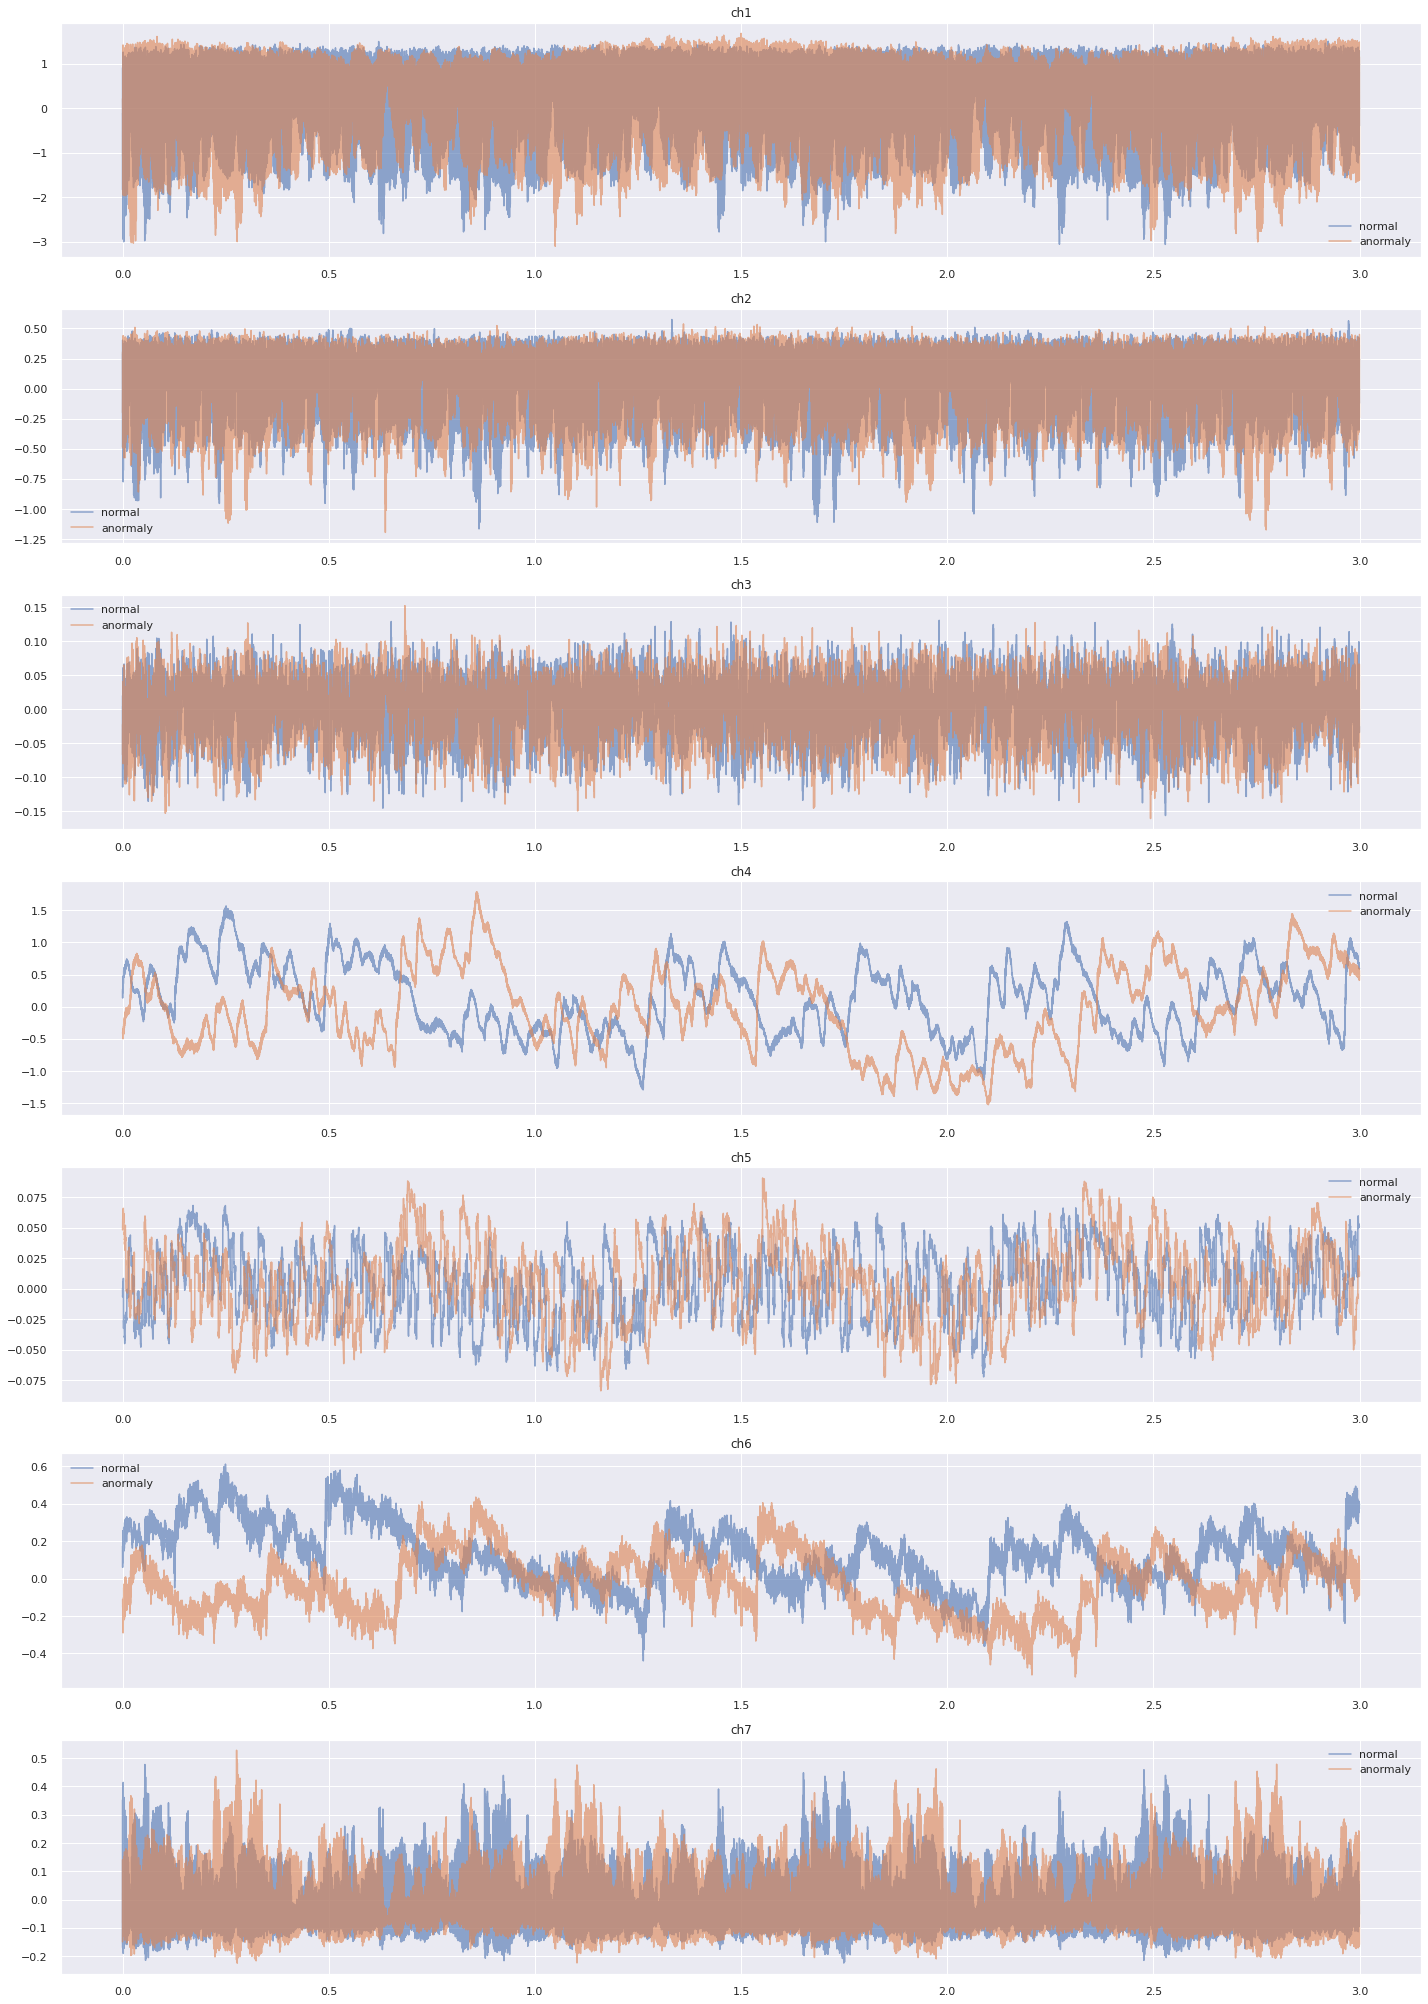

In [70]:
# 並べて比較してみる
sns.set()
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 4*7))

for i, colname in enumerate(COL_NAMES):
    axes[i].plot(np.arange(len(sample)) / sampling_rate, sample[colname], label='normal', alpha=0.6)
    axes[i].plot(np.arange(len(an_sample)) / sampling_rate, an_sample[colname], label='anormaly', alpha=0.6)
    axes[i].legend()
    axes[i].set_title(colname)
fig.tight_layout()


In [300]:
# data_train_normal = np.empty((0,15000,7))
# for f in glob.glob(os.path.join(DIR_TRAIN_NORMAL, "normal_*.csv")):
#     data_train_normal = np.concatenate([data_train_normal,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

# data_train_anomaly = np.empty((0,15000,7))
# for f in glob.glob(os.path.join(DIR_TRAIN_ANOMALY, "anomaly_*.csv")):
#     data_train_anomaly = np.concatenate([data_train_anomaly,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

# data_test = np.empty((0,15000,7))
# for f in glob.glob(os.path.join(DIR_TEST, "data_*.csv")):
#     data_test = np.concatenate([data_test,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

In [301]:
# print(data_train_normal.shape)
# print(data_train_anomaly.shape)
# print(data_test.shape)

In [71]:
# 線形補間
def interpolate(data):
    data = pd.DataFrame(data).interpolate(axis=0)
    return data

In [72]:
sample = interpolate(sample)
an_sample = interpolate(an_sample)

sample.columns = COL_NAMES
an_sample.columns = COL_NAMES

In [73]:
sample

,ch1,ch2,ch3,ch4,ch5,ch6,ch7
0,0.910090,0.402490,0.019964,0.27151,0.000467,0.173220,-0.168900
1,-1.833200,-0.487320,-0.114280,0.13633,-0.006630,0.060084,0.353070
2,-0.106670,0.290530,0.004620,0.24565,-0.005084,0.151340,-0.155250
3,-0.646520,-0.359190,-0.072506,0.21659,-0.006098,0.133470,0.248640
4,-1.559200,-0.108140,-0.037739,0.24092,-0.000007,0.115670,-0.010415
...,...,...,...,...,...,...,...
14995,-0.148250,-0.233680,0.011358,0.60756,0.050518,0.372310,0.034148
14996,-0.066342,0.159220,0.030639,0.60008,0.051698,0.372870,-0.091923
14997,0.813900,-0.010019,-0.000293,0.60753,0.050665,0.384450,0.020348
14998,-0.397290,-0.122370,-0.034219,0.58543,0.051191,0.372720,-0.015185


In [74]:
sample.isnull().sum()

ch1    0
ch2    0
ch3    0
ch4    0
ch5    0
ch6    0
ch7    0
dtype: int64

In [75]:
# フーリエ変換
# データ取得間隔 50kHz 
n_frame = 15000 # 分割窓のコマ数
time_step = 1/ sampling_rate # 1/ 50kHz

In [76]:
time_step

0.0002

In [77]:
han = signal.hann(n_frame) #ハニング窓を作成

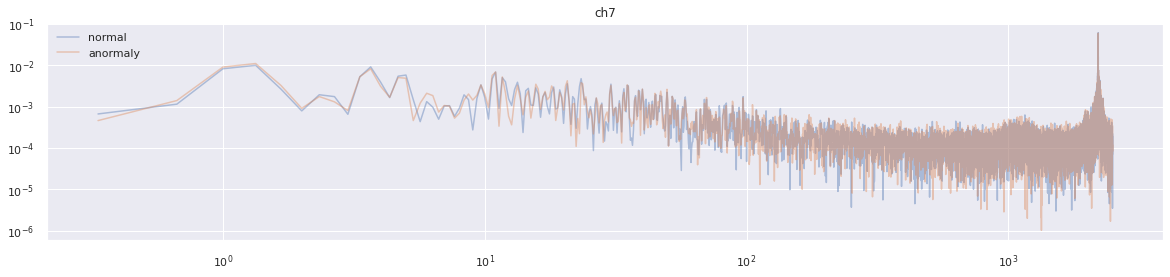

In [84]:
ch = 'ch7'

plt.rcParams["figure.figsize"] = [20,4.0]
sample_freq = fftpack.fftfreq(len(sample), d=time_step)  # 周波数軸を生成
y_fft = np.fft.fft((han)*(sample[ch]-np.mean(sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
pidxs = np.where(sample_freq > 0)

freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]

an_sample_freq = fftpack.fftfreq(len(an_sample), d=time_step)  # 周波数軸を生成
an_y_fft = np.fft.fft((han)*(an_sample[ch]-np.mean(an_sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
an_pidxs = np.where(an_sample_freq > 0)

an_freqs, an_power = an_sample_freq[an_pidxs], np.abs(an_y_fft)[an_pidxs]

plt.loglog(freqs, power, label = 'normal', alpha = 0.4)
plt.loglog(an_freqs, an_power , label = 'anormaly', alpha = 0.4)
plt.title(ch)
plt.legend()

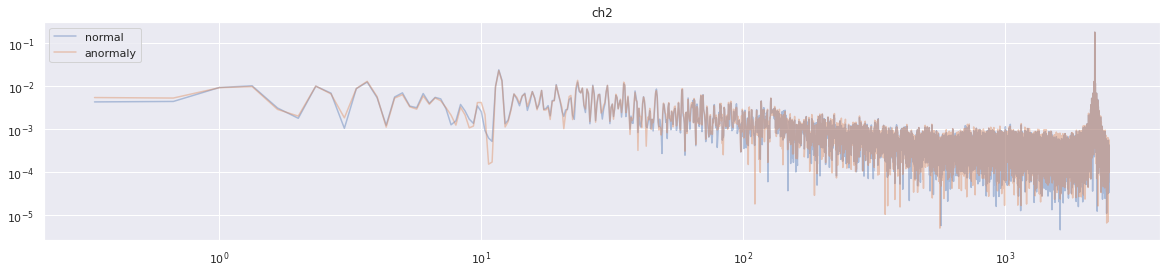

In [310]:
ch = 'ch2'

plt.rcParams["figure.figsize"] = [20,4.0]
sample_freq = fftpack.fftfreq(len(sample), d=time_step)  # 周波数軸を生成
y_fft = np.fft.fft((han)*(sample[ch]-np.mean(sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
pidxs = np.where(sample_freq > 0)

freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]

an_sample_freq = fftpack.fftfreq(len(an_sample), d=time_step)  # 周波数軸を生成
an_y_fft = np.fft.fft((han)*(an_sample[ch]-np.mean(an_sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
an_pidxs = np.where(an_sample_freq > 0)

an_freqs, an_power = an_sample_freq[an_pidxs], np.abs(an_y_fft)[an_pidxs]

plt.loglog(freqs, power, label = 'normal', alpha = 0.4)
plt.loglog(an_freqs, an_power , label = 'anormaly', alpha = 0.4)
plt.title(ch)
plt.legend()

In [265]:
# ヒルベルト変換と絶対値処理を実行し包絡線を得る ⇒　うまくいかない？　周波数が一定でないから？
# amplitude_envelope = np.abs(signal.hilbert(an_sample['ch1']) )

In [22]:
plt.rcParams["figure.figsize"] = [20,4.0]
an_low = lowess(an_sample['ch1'], an_sample.index,  frac=1/100)[:,1]
low = lowess(sample['ch1'], sample.index,  frac=1/100)[:,1]

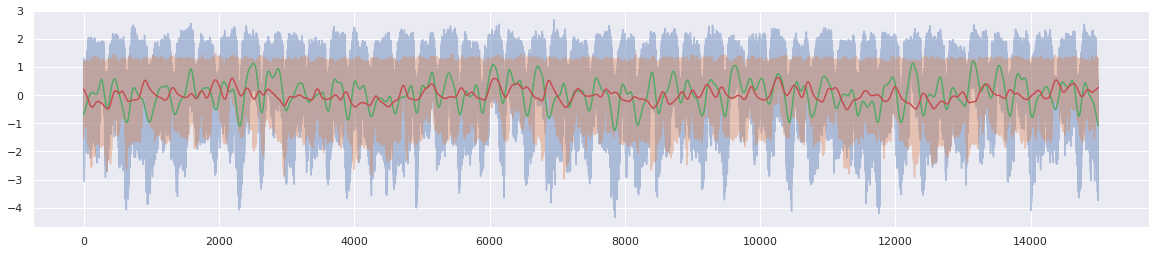

In [23]:
plt.plot(an_sample['ch1'], alpha=0.4)
plt.plot(sample['ch1'], alpha=0.4)
plt.plot(an_low)
plt.plot(low)

フーリエ変換マックス値  
平滑化した波形の何か  
統計量の特徴量  

1ch毎に複数特徴量を作成しデータフレーム化、テーブルデータとして解く  

すペクトグラムで画像として解く  

In [264]:
# テーブルとして解いてみる
norm_filelist = glob.glob(DIR_TRAIN_NORMAL + '*')
anom_filelist = glob.glob(DIR_TRAIN_ANOMALY + '*')

In [275]:
# 通常データ
sample = pd.read_csv(anom_filelist[1], header=None)
sample.columns = COL_NAMES
sample['No'] = "No1"
sample

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,No
0,-1.044395,-0.284011,-0.060005,0.227359,-0.002968,-0.077350,0.241384,No1
1,0.334525,0.359404,0.042619,0.277579,0.005034,-0.022053,-0.146321,No1
2,-0.025104,-0.112692,-0.028935,0.255261,-0.021800,-0.048026,0.183740,No1
3,-0.665610,0.085432,0.006049,0.207041,-0.029635,-0.083887,-0.041829,No1
4,1.027611,0.125139,0.023614,0.274906,-0.021294,-0.000934,0.043594,No1
...,...,...,...,...,...,...,...,...
14995,-1.159329,0.112825,-0.051631,0.064081,0.005173,0.062675,-0.046360,No1
14996,0.428232,-0.072713,-0.058007,0.100059,0.004243,0.105965,0.142581,No1
14997,-2.266332,-0.305641,-0.088658,0.029770,0.000120,-0.008950,0.142035,No1
14998,1.231287,0.264377,0.015692,0.198666,0.000313,0.143835,-0.034910,No1


In [276]:
sample.isnull().sum()

ch1    10
ch2    15
ch3    11
ch4     8
ch5    13
ch6    16
ch7     0
No      0
dtype: int64

In [277]:
# 基本統計量
tmp = sample.groupby('No', group_keys=False).agg([np.mean, np.max, np.min])

In [278]:
# https://stackoverflow.com/questions/47666438/how-to-groupby-aggregate-on-multiple-columns-and-rename-the-multi-index-in-pan
tmp.columns = tmp.columns.map('_'.join)

In [279]:
tmp

,ch1_mean,ch1_amax,ch1_amin,ch2_mean,ch2_amax,ch2_amin,ch3_mean,ch3_amax,ch3_amin,ch4_mean,...,ch4_amin,ch5_mean,ch5_amax,ch5_amin,ch6_mean,ch6_amax,ch6_amin,ch7_mean,ch7_amax,ch7_amin
No,,,,,,,,,,,,,,,,,,,,,
No1,0.02067,1.74756,-3.249675,0.0013,0.592609,-1.217242,0.000498,0.146135,-0.157442,0.39801,...,-0.994684,0.00406,0.084895,-0.078091,0.100056,0.63209,-0.379436,0.007992,0.498441,-0.218506


In [280]:
# フーリエ変換
# データ取得間隔 50kHz 
sampling_rate = 5000
n_frame = 15000 # 分割窓のコマ数
time_step = 1/ sampling_rate # 1/ 50kHz

def fourier(sample, ch):
    '''
    フーリエ変換後、1Hz以上の範囲で最大値になる周波数を返す
    sample : dataframe
    ch : channel name
    '''
    sample_freq = fftpack.fftfreq(len(sample), d=time_step)  # 周波数軸を生成
    y_fft = np.fft.fft((han)*(sample[ch]-np.mean(sample[ch])))/(n_frame/2)  # フーリエスペクトル（複素数）
    pidxs = np.where(sample_freq > 0)

    freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
    
    mfreq = freqs[freqs >= 10**1][power[freqs >= 10**1].argmax()] # ピーク周波数
    return mfreq

In [281]:
x = pd.Series()
for i, colname in enumerate(COL_NAMES):
    fft_temp = pd.Series(fourier(sample=an_sample, ch=colname))
    x = pd.concat([x, fft_temp], axis=0)
x = list(x)

In [282]:
tmp

,ch1_mean,ch1_amax,ch1_amin,ch2_mean,ch2_amax,ch2_amin,ch3_mean,ch3_amax,ch3_amin,ch4_mean,...,ch4_amin,ch5_mean,ch5_amax,ch5_amin,ch6_mean,ch6_amax,ch6_amin,ch7_mean,ch7_amax,ch7_amin
No,,,,,,,,,,,,,,,,,,,,,
No1,0.02067,1.74756,-3.249675,0.0013,0.592609,-1.217242,0.000498,0.146135,-0.157442,0.39801,...,-0.994684,0.00406,0.084895,-0.078091,0.100056,0.63209,-0.379436,0.007992,0.498441,-0.218506


In [283]:
x

[2202.6666666666665,
 2202.6666666666665,
 30.666666666666664,
 15.333333333333332,
 30.666666666666664,
 30.666666666666664,
 2202.6666666666665]

In [284]:
for i, colname in enumerate(COL_NAMES):
    new_col = colname + '_fft'
    tmp[new_col] = x[i]

In [285]:
tmp

,ch1_mean,ch1_amax,ch1_amin,ch2_mean,ch2_amax,ch2_amin,ch3_mean,ch3_amax,ch3_amin,ch4_mean,...,ch7_mean,ch7_amax,ch7_amin,ch1_fft,ch2_fft,ch3_fft,ch4_fft,ch5_fft,ch6_fft,ch7_fft
No,,,,,,,,,,,,,,,,,,,,,
No1,0.02067,1.74756,-3.249675,0.0013,0.592609,-1.217242,0.000498,0.146135,-0.157442,0.39801,...,0.007992,0.498441,-0.218506,2202.666667,2202.666667,30.666667,15.333333,30.666667,30.666667,2202.666667


# interpolate
データの欠損を補完します。今回は線形補完を実施します。

In [5]:
print(np.sum(np.isnan(data_train_normal)))
# print(np.sum(np.isnan(data_train_normal)))
# print(np.sum(np.isnan(data_train_normal)))

4876


In [6]:
def interpolate(data):
    for i in range(data.shape[0]):
        data[i,:,:] = pd.DataFrame(data[i,:,:]).interpolate(axis=0).values
    return data

data_train_normal = interpolate(data_train_normal)
data_train_anomal = interpolate(data_train_anomaly)
data_test = interpolate(data_test)

In [7]:
print(np.sum(np.isnan(data_train_normal)))

0


# split data
* 学習データをtrainとvalidationにランダムに分割します。
* 正解ラベルを作成します。

In [8]:
# Shuffle train data for validation
## make index list
index_normal = np.arange(0,data_train_normal.shape[0])
index_anomaly = np.arange(0,data_train_anomaly.shape[0])

## shuffle index
np.random.seed(seed=2021)
np.random.shuffle(index_normal)
np.random.shuffle(index_anomaly)

In [9]:
# make train val index
train_size = 0.7
nl = round(len(index_normal)*train_size)
al = round(len(index_anomaly)*train_size)

train_index_normal = index_normal[:nl]
val_index_normal = index_normal[nl:]
train_index_anomaly = index_anomaly[:al]
val_index_anomaly = index_anomaly[al:]

print(len(train_index_normal),len(val_index_normal))
print(len(train_index_anomaly),len(val_index_anomaly))

245 105
63 27


In [10]:
# split X
data_X_train = np.concatenate([data_train_normal[train_index_normal], 
                               data_train_anomaly[train_index_anomaly]], axis=0)
data_X_val = np.concatenate([data_train_normal[val_index_normal], 
                             data_train_anomaly[val_index_anomaly]], axis=0)
data_X_test = data_test
print(f"train:{data_X_train.shape}, val:{data_X_val.shape} test:{data_X_test.shape}")

train:(308, 15000, 7), val:(132, 15000, 7) test:(480, 15000, 7)


In [11]:
# split y
y_train = np.concatenate([[0 for i in range(data_train_normal[train_index_normal].shape[0])], 
                          [1 for i in range(data_train_anomaly[train_index_anomaly].shape[0])]])
y_val = np.concatenate([[0 for i in range(data_train_normal[val_index_normal].shape[0])], 
                        [1 for i in range(data_train_anomaly[val_index_anomaly].shape[0])]])

# train model
* モデルにインプットするデータを標準化します。
* trainデータを使いTimeSeriesForestClassifierモデルを学習します
  * 参考：
  * https://www.sktime.org/en/stable/api_reference/modules/auto_generated/sktime.classification.interval_based.TimeSeriesForestClassifier.html#sktime.classification.interval_based.TimeSeriesForestClassifier
* validationデータで精度を検証します。

In [12]:
scaler = StandardScaler()
sc = scaler.fit(data_X_train.reshape(-1,data_X_train.shape[2]))

data_X_train_norm = sc.transform(data_X_train.reshape(-1,data_X_train.shape[2]))
data_X_train_norm = data_X_train_norm.reshape(data_X_train.shape)

data_X_val_norm = sc.transform(data_X_val.reshape(-1,data_X_val.shape[2]))
data_X_val_norm = data_X_val_norm.reshape(data_X_val.shape)

data_X_test_norm = sc.transform(data_X_test.reshape(-1,data_X_test.shape[2]))
data_X_test_norm = data_X_test_norm.reshape(data_X_test.shape)

In [14]:
# 今回は計算時間短縮のためデータをカット
ts = 5000
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(data_X_train_norm[:,:ts,:], y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify', TimeSeriesForestClassifier(n_estimators=100))])

In [15]:
y_val_pred = clf.predict(data_X_val_norm[:,:ts,:])
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.55      0.41      0.47        27

    accuracy                           0.81       132
   macro avg       0.70      0.66      0.68       132
weighted avg       0.79      0.81      0.80       132



In [16]:
y_val_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

 # predict test
 * テストデータの予測値を算出し、submit用のCSVファイルを出力します。
 

In [17]:
y_test_pred = clf.predict(data_X_test_norm[:,:ts,:])

In [18]:
 y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [19]:
sub = pd.read_csv("sample_submission.csv", header=None)
sub.iloc[:,1] = y_test_pred
sub.to_csv("submission.csv", index=False, header=False)